In [1]:
%matplotlib inline

import logging
import sys
import re
from os.path import join as pjoin

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from matplotlib import pyplot as plt

import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.feature as feature
import scipy.stats as stats

In [2]:
sys.path.append('../scripts')
import TCLVscaling
logging.disable(logging.INFO)

15:17:41: <module>: Started /home/jami/.anaconda3/envs/tcrm-r/lib/python3.7/site-packages/ipykernel_launcher.py (pid 26429)
15:17:41: <module>: Code version: funknown


In [3]:
path = "../data/tclv"
regex = r'all_tracks_(.+)_(rcp\d+)\.dat'
labels = ['TD', 'TC1', 'TC2', 'TC3', 'TC4', 'TC5']
catpal = sns.blend_palette([(0.000, 0.627, 0.235), (0.412, 0.627, 0.235), 
                            (0.663, 0.780, 0.282), (0.957, 0.812, 0.000), 
                            (0.925, 0.643, 0.016), (0.835, 0.314, 0.118),
                            (0.780, 0.086, 0.118)], 6)
domain = [135, 160, -25, -10]
dist = stats.lognorm

In [4]:
obstc = TCLVscaling.loadObsData('../data/ibtracs.since1980.list.v04r00.csv', domain)
obsparams = stats.lognorm.fit(obstc.pdiff)

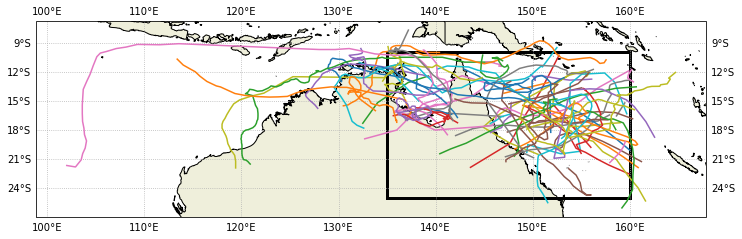

In [5]:
fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m', color='black', linewidth=1)
ax.add_feature(feature.BORDERS)
gl = ax.gridlines(linestyle=":", draw_labels=True)
ax.add_feature(feature.LAND, zorder=0)

for k, v in obstc.groupby('num'):
    ax.plot(v['lon'], v['lat'])
    
ax.add_patch(mpatches.Rectangle(xy=[135, -25], width=25, height=15,
                                fill=False, edgecolor='k', linewidth=3,
                                transform=ccrs.PlateCarree()))

plt.savefig(pjoin(path, "observed_tracks.png"), bbox_inches='tight')

In [6]:
refdata = TCLVscaling.loadTCLVdata(path, 1980, 2010, domain)
for key, df in refdata.items():
    refdata[key] = df[df['pdiff'] > 0]
refdata = TCLVscaling.append_ensembles(refdata)

In [7]:
def plot_model_dists(data):
    fig, axes = plt.subplots(6,4, figsize=(20,20), sharex=True)
    ax = axes.flatten()
    result = pd.DataFrame(columns=['Model', 'RCP', 'mu', 'sigma', 'zeta'])
    for i, (m, df) in enumerate(data.items()):
        sns.distplot(df.pdiff, ax=ax[i], kde=False, norm_hist=True)
        model, rcp = m.split(' ')
        popt = stats.lognorm.fit(df.pdiff, loc=0, scale=1)
        result = result.append({'Model':model, 'RCP':rcp, 
                                'mu':popt[0], 'sigma':popt[1], 'zeta':popt[2]},
                               ignore_index=True)
        fitline = stats.lognorm.pdf(np.arange(0, 101), *popt, )
        ax[i].plot(np.arange(0,101), fitline, color='r')
        ax[i].set_title("{0}\n({1:.4f}, {2:.4f}, {3:.4f})".format(m, *popt))
    
    fig.tight_layout()

    return result   

def plot_model_params(params):
    fig, ax = plt.subplots(1, 2, figsize=(12,5), sharey=True)
    x = np.arange(0, 100)

    def plot_ensemble(axes, ensemble):
        for index, row in refparams[refparams['RCP']==ensemble].iterrows():
            popt = (row.mu, row.sigma, row.zeta)
            fitline = stats.lognorm.pdf(x, *popt)
            if row.Model == 'ENS':
                axes.plot(x, fitline, color='b')
            else:
                axes.plot(x, fitline, color='k')

        axes.plot(x, stats.lognorm.pdf(x, *obsparams), 'r', label='Observations')
        axes.set_xlabel(r"$\Delta p_c$ (hPa)")
    
    plot_ensemble(ax[0], 'RCP45')
    ax[0].set_title("RCP4.5")

    plot_ensemble(ax[1], 'RCP85')
    ax[1].set_title("RCP8.5")

    ax[0].set_ylabel("Probability")
    ax[1].legend()
    fig.tight_layout()

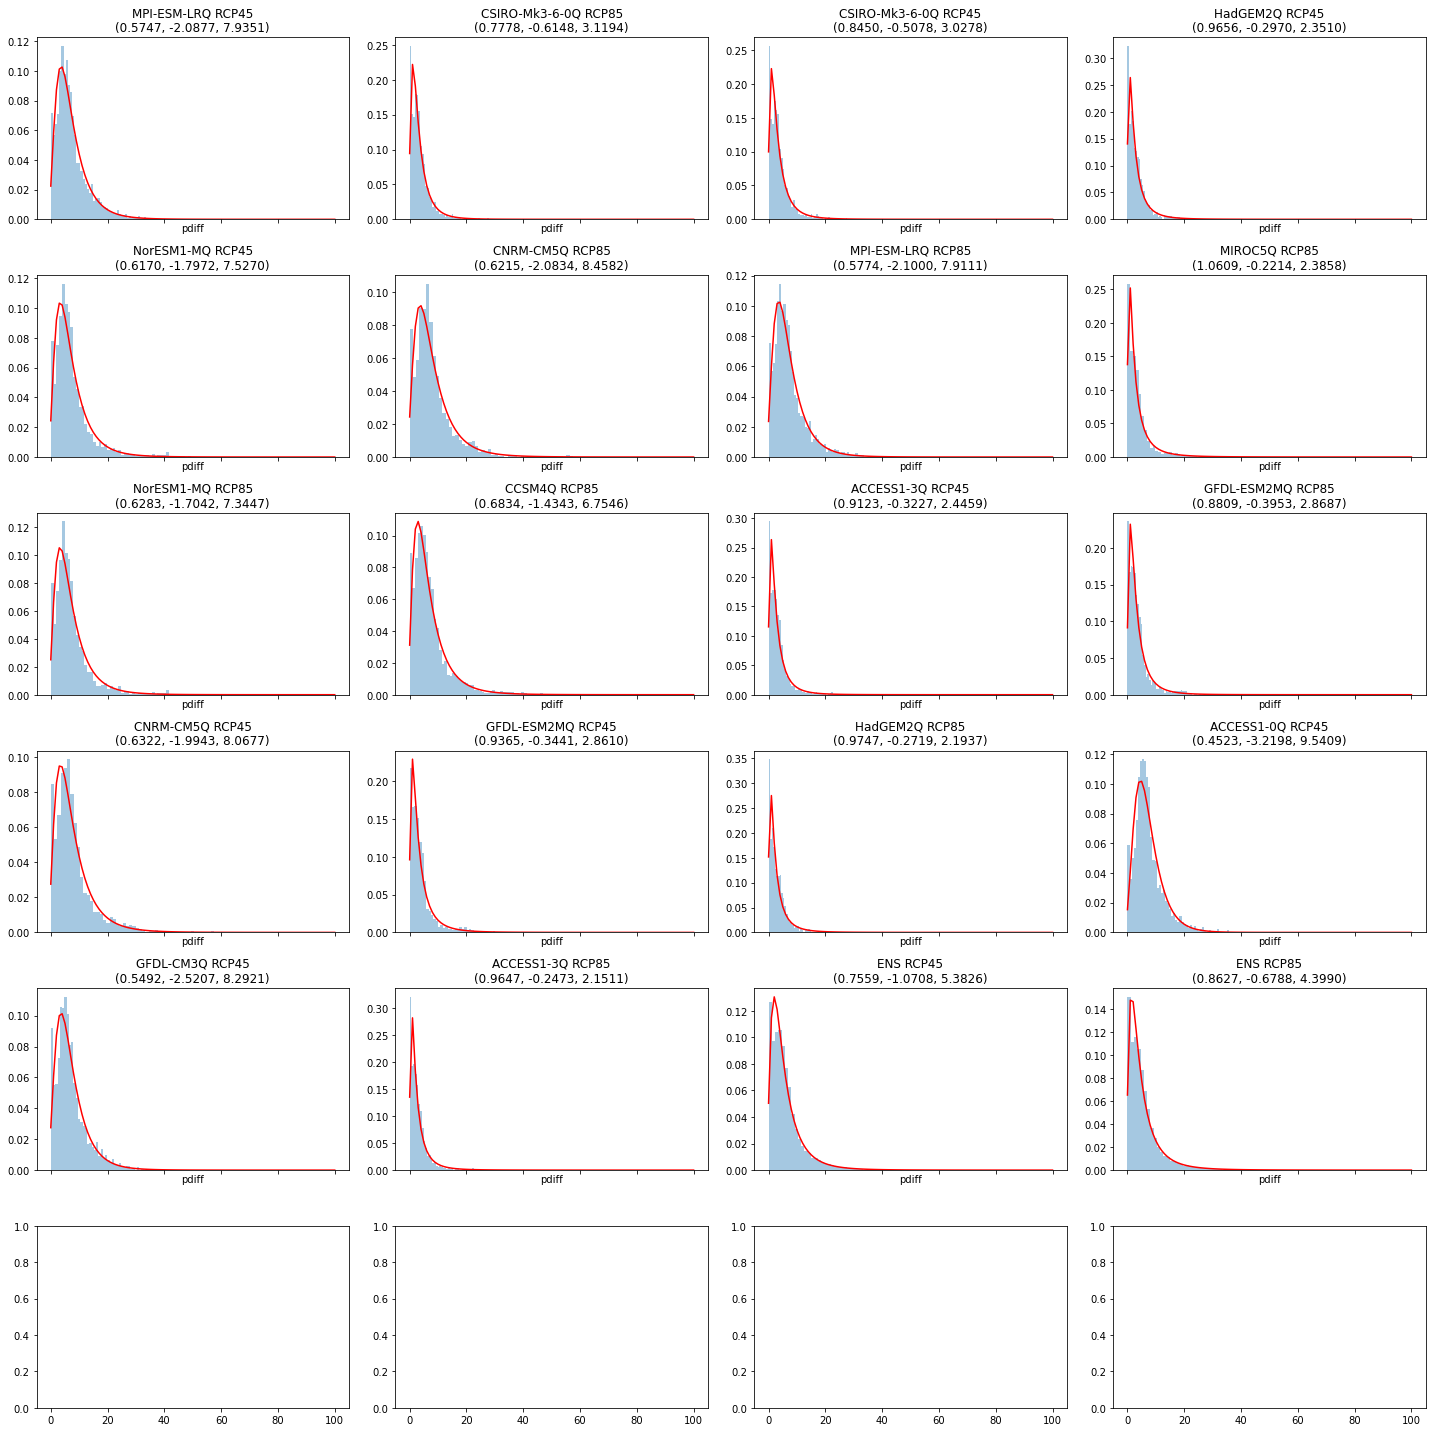

In [8]:
refparams = plot_model_dists(refdata)
plt.savefig(pjoin(path, "reference_distribution.png"), bbox_inches='tight')

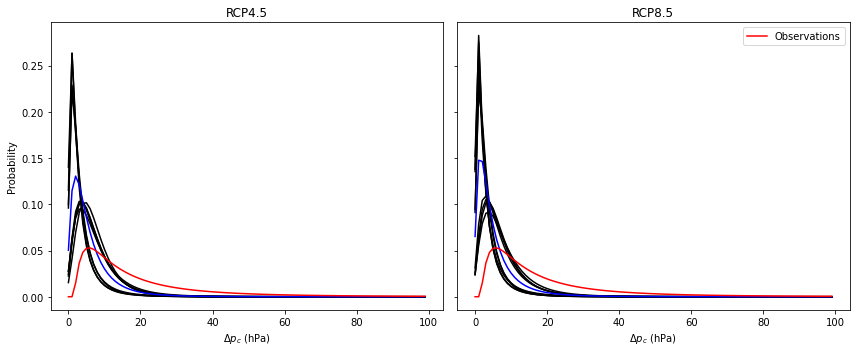

In [9]:
plot_model_params(refparams)
plt.savefig(pjoin(path, 'uncorrected_distribution_by_RCP_reference.png'), bbox_inches='tight')

In [10]:
refparams.groupby(['RCP']).agg('mean')

,mu,sigma,zeta
RCP,,,
RCP45,0.724059,-1.416205,5.743105
RCP85,0.803229,-0.975143,4.758627


In [11]:
futdata = TCLVscaling.loadTCLVdata(path, 2081, 2100, domain)
for key, df in futdata.items():
    futdata[key] = df[df['pdiff'] > 0]
futdata = TCLVscaling.append_ensembles(futdata)

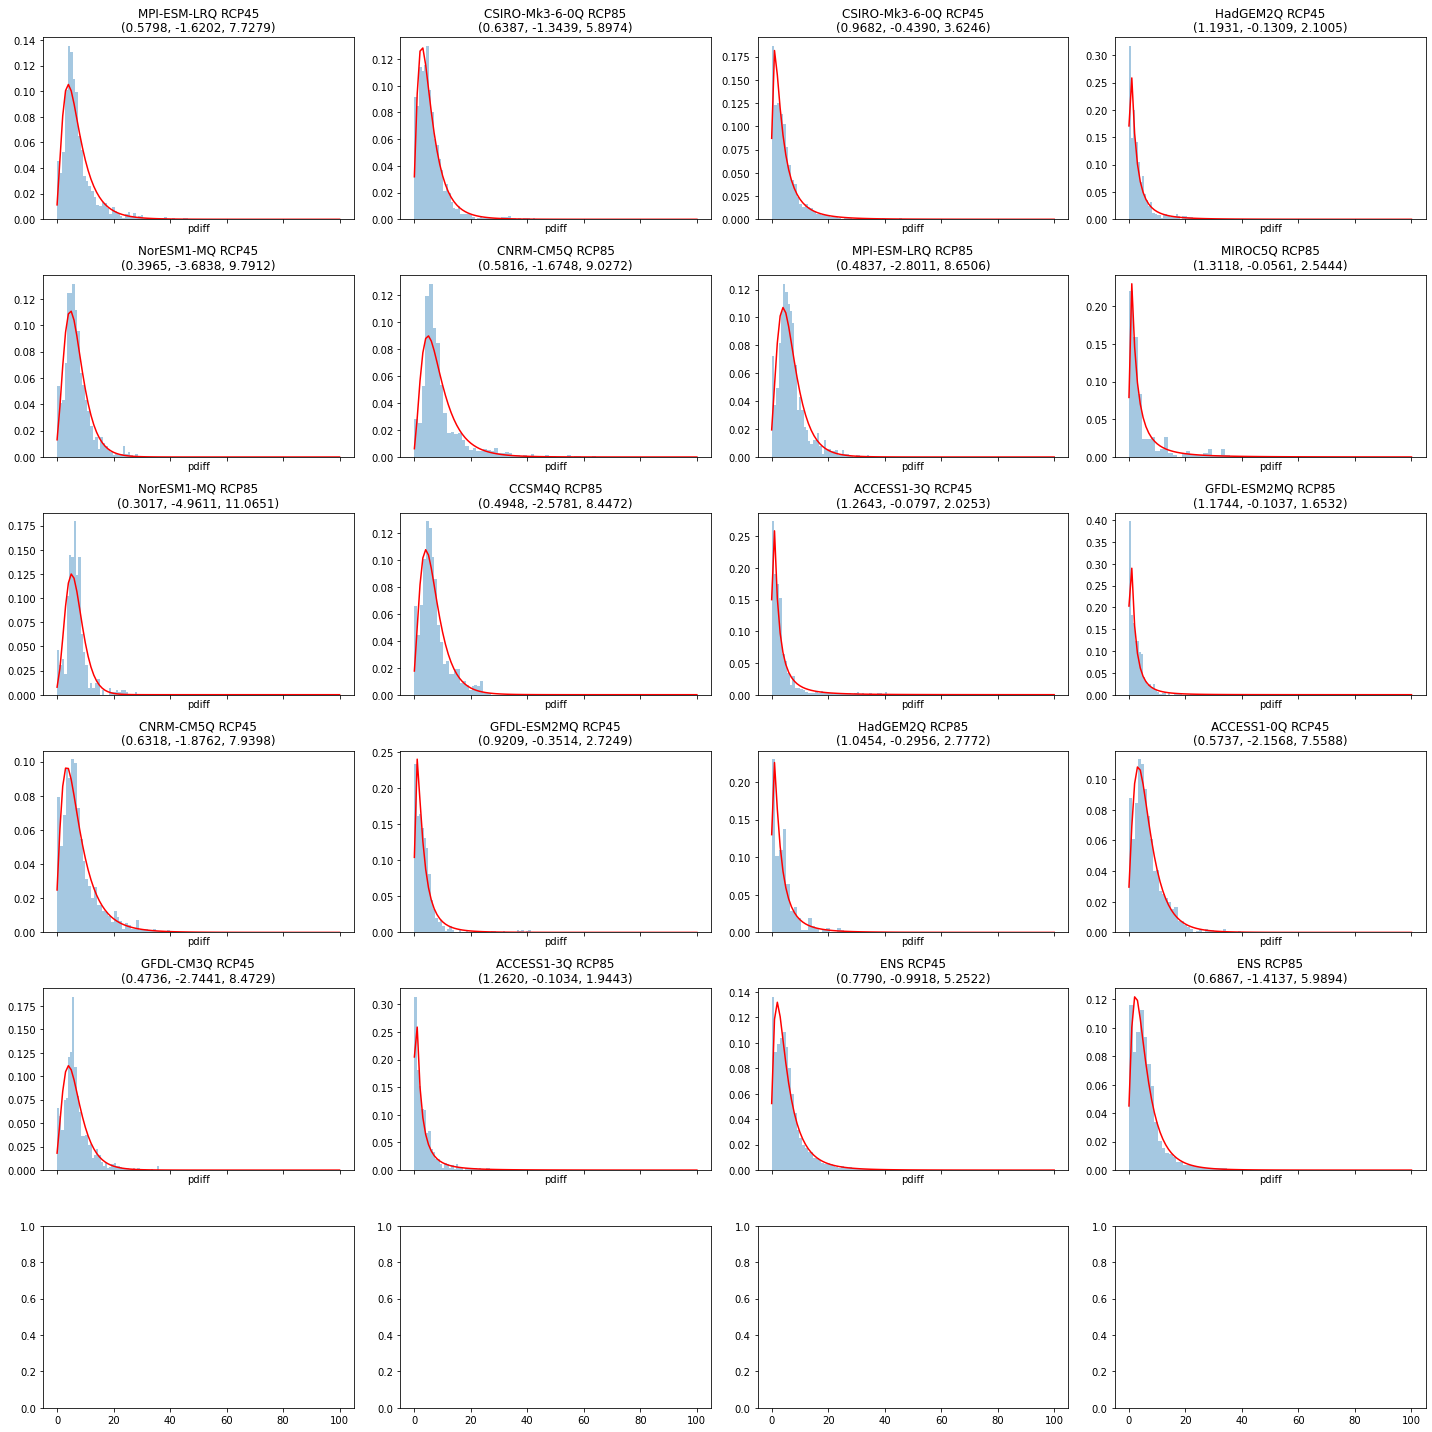

In [12]:
futparams = plot_model_dists(futdata)
plt.savefig(pjoin(path, "future_distribution.png"), bbox_inches='tight')

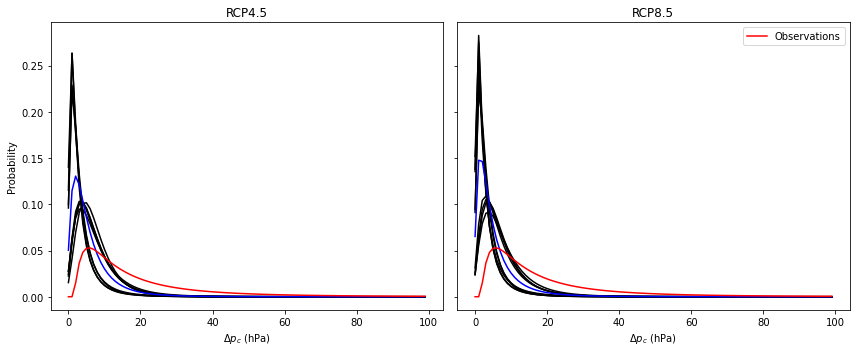

In [13]:
plot_model_params(futparams)
plt.savefig(pjoin(path, 'uncorrected_distribution_by_RCP_future.png'), bbox_inches='tight')

In [14]:
futparams.groupby('RCP').agg('mean')

,mu,sigma,zeta
RCP,,,
RCP45,0.778085,-1.407387,5.721803
RCP85,0.798071,-1.533152,5.799593


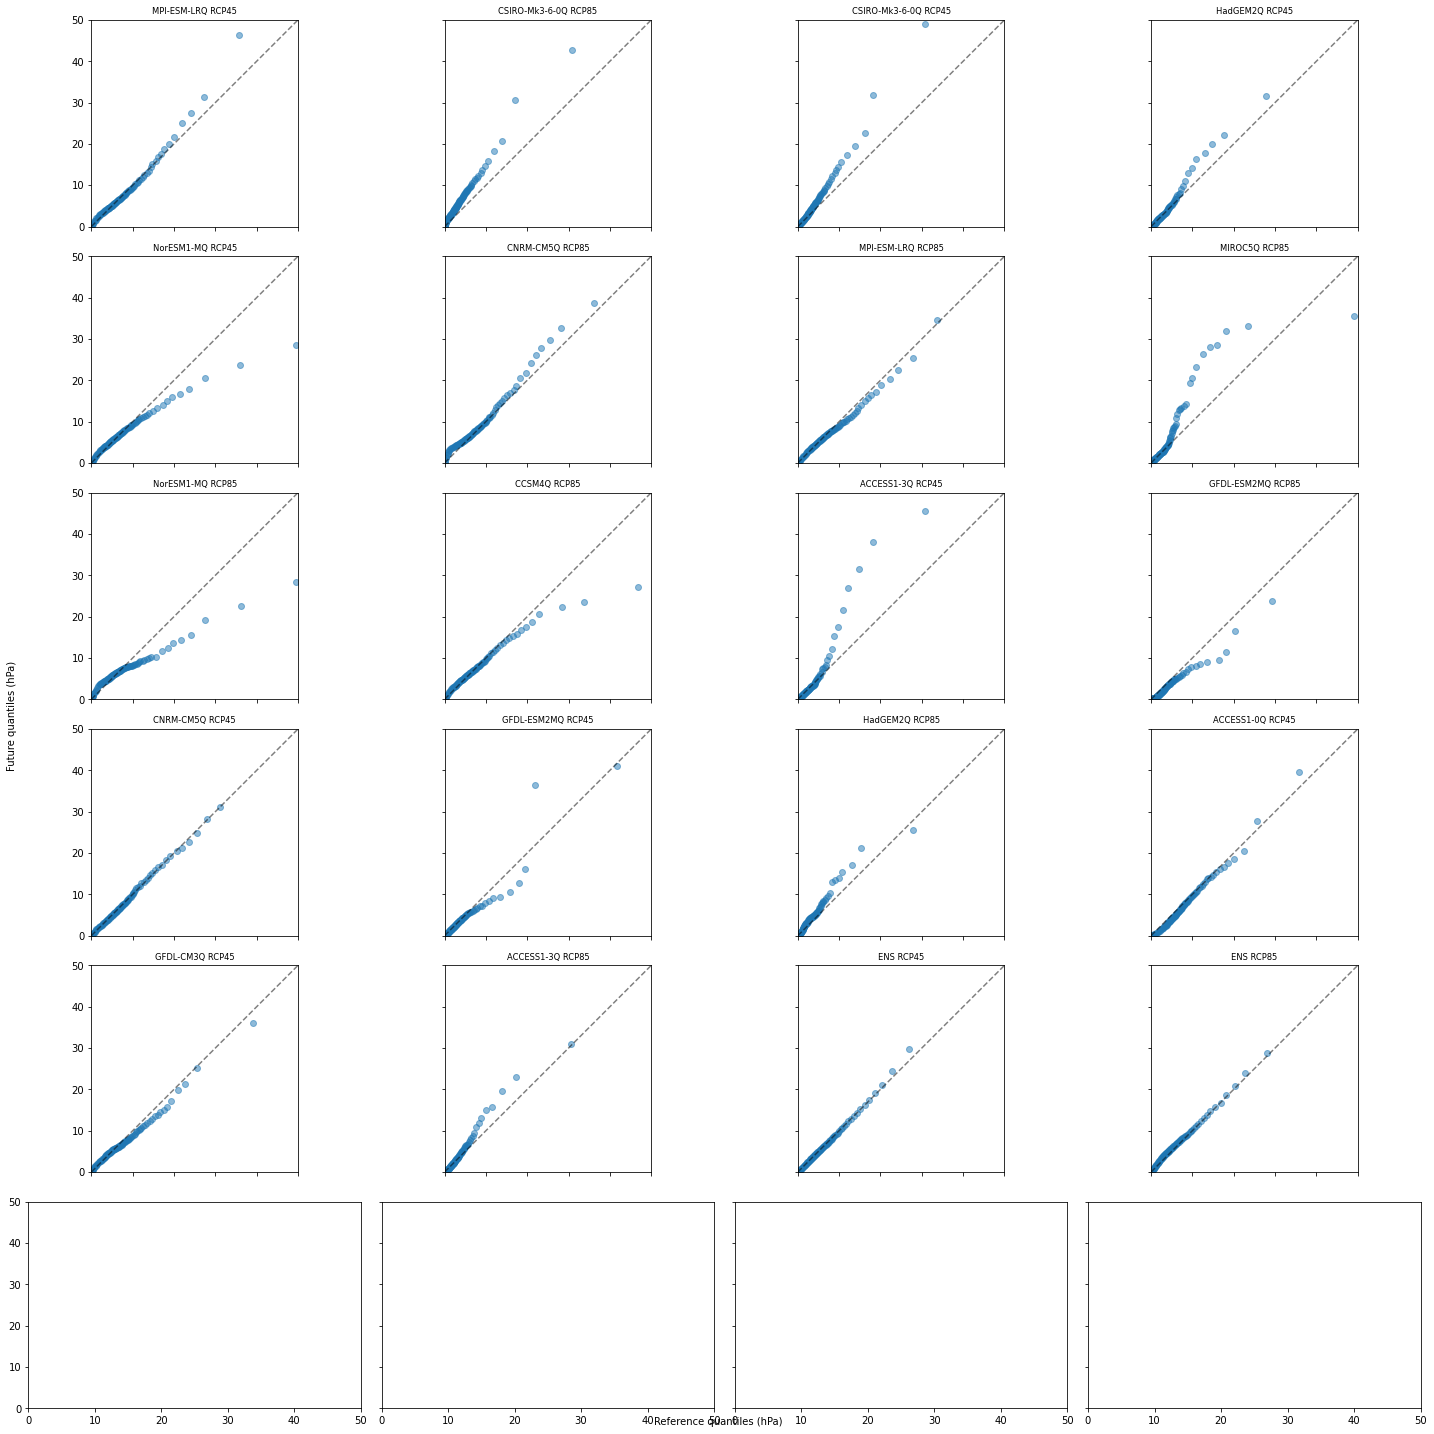

In [15]:
fig, axes = plt.subplots(6, 4, figsize=(20, 20), sharex=True, sharey=True)
ax = axes.flatten()
x = np.linspace(0, 1, 101)
for i, (m, refdf) in enumerate(refdata.items()):
    futdf = futdata[m]
    model, rcp = m.split(' ')

    srefdata = refdf.pdiff.values
    sfutdata = futdf.pdiff.values
    srefq = np.quantile(srefdata, x)
    sfutq = np.quantile(sfutdata, x)
    ax[i].scatter(srefq, sfutq, alpha=0.5)
    ax[i].plot([0, 50], [0,50], '--', color='k', alpha=0.5)
    ax[i].set_title(m, size='small')
    ax[i].set_xlim((0, 50))
    ax[i].set_ylim((0, 50))
    ax[i].set_aspect('equal')
    
fig.tight_layout()
fig.text(0.5, 0.01, "Reference quantiles (hPa)", ha='center', va='center')
fig.text(0.01, 0.5, "Future quantiles (hPa)", ha='center', va='center', rotation='vertical')
plt.savefig(pjoin(path, 'ref_fut_quantiles.png'), bbox_inches='tight')

# Apply QDM

In [16]:
brefdata = {}
bfutdata = {}
obslmi = obstc.loc[obstc.groupby(["num"])["pdiff"].idxmax()]

for i, (m, refdf) in enumerate(refdata.items()):
    futdf = futdata[m]
         
    # Determine LMI for each event in the reference and projected data
    try:
        srefdata = refdf.loc[refdf.groupby('num')["pdiff"].idxmax()].set_index(['num'])
        sfutdata = futdf.loc[futdf.groupby('num')["pdiff"].idxmax()].set_index(['num'])
    except:
        print(f"Reference data: {refdf.groupby('num')['pdiff'].idxmax():.2f}")
        print(f"Projected data: {futdf.groupby('num')['pdiff'].idxmax():.2f}")
        
    # Calculate the bias-corrected LMI
    try:
        srefdata['blmi'], sfutdata['blmi'] = TCLVscaling.qdm(obslmi.pdiff.values,
                                                             srefdata.pdiff.values,
                                                             sfutdata.pdiff.values)
    except:
        print(f"QDM failed for {m}")
        raise
        
    brefdf = refdf.copy()
    bfutdf = futdf.copy()
    
    newdf = pd.merge(brefdf, srefdata['blmi'], on='num')
    brefdf['pdiff'] = brefdf['ni'].values * newdf['blmi'].values
    brefdf['pmin'] = brefdf['poci'] - brefdf['pdiff']
    brefdf = TCLVscaling.calculateMaxWind(brefdf, 'datetime')

    newdf = pd.merge(bfutdf, sfutdata['blmi'], on='num')
    bfutdf['pdiff'] = bfutdf['ni'].values * newdf['blmi'].values
    bfutdf['pmin'] = bfutdf['poci'] - bfutdf['pdiff']
    bfutdf = TCLVscaling.calculateMaxWind(bfutdf, 'datetime')
    
    brefdata[m] = brefdf
    bfutdata[m] = bfutdf

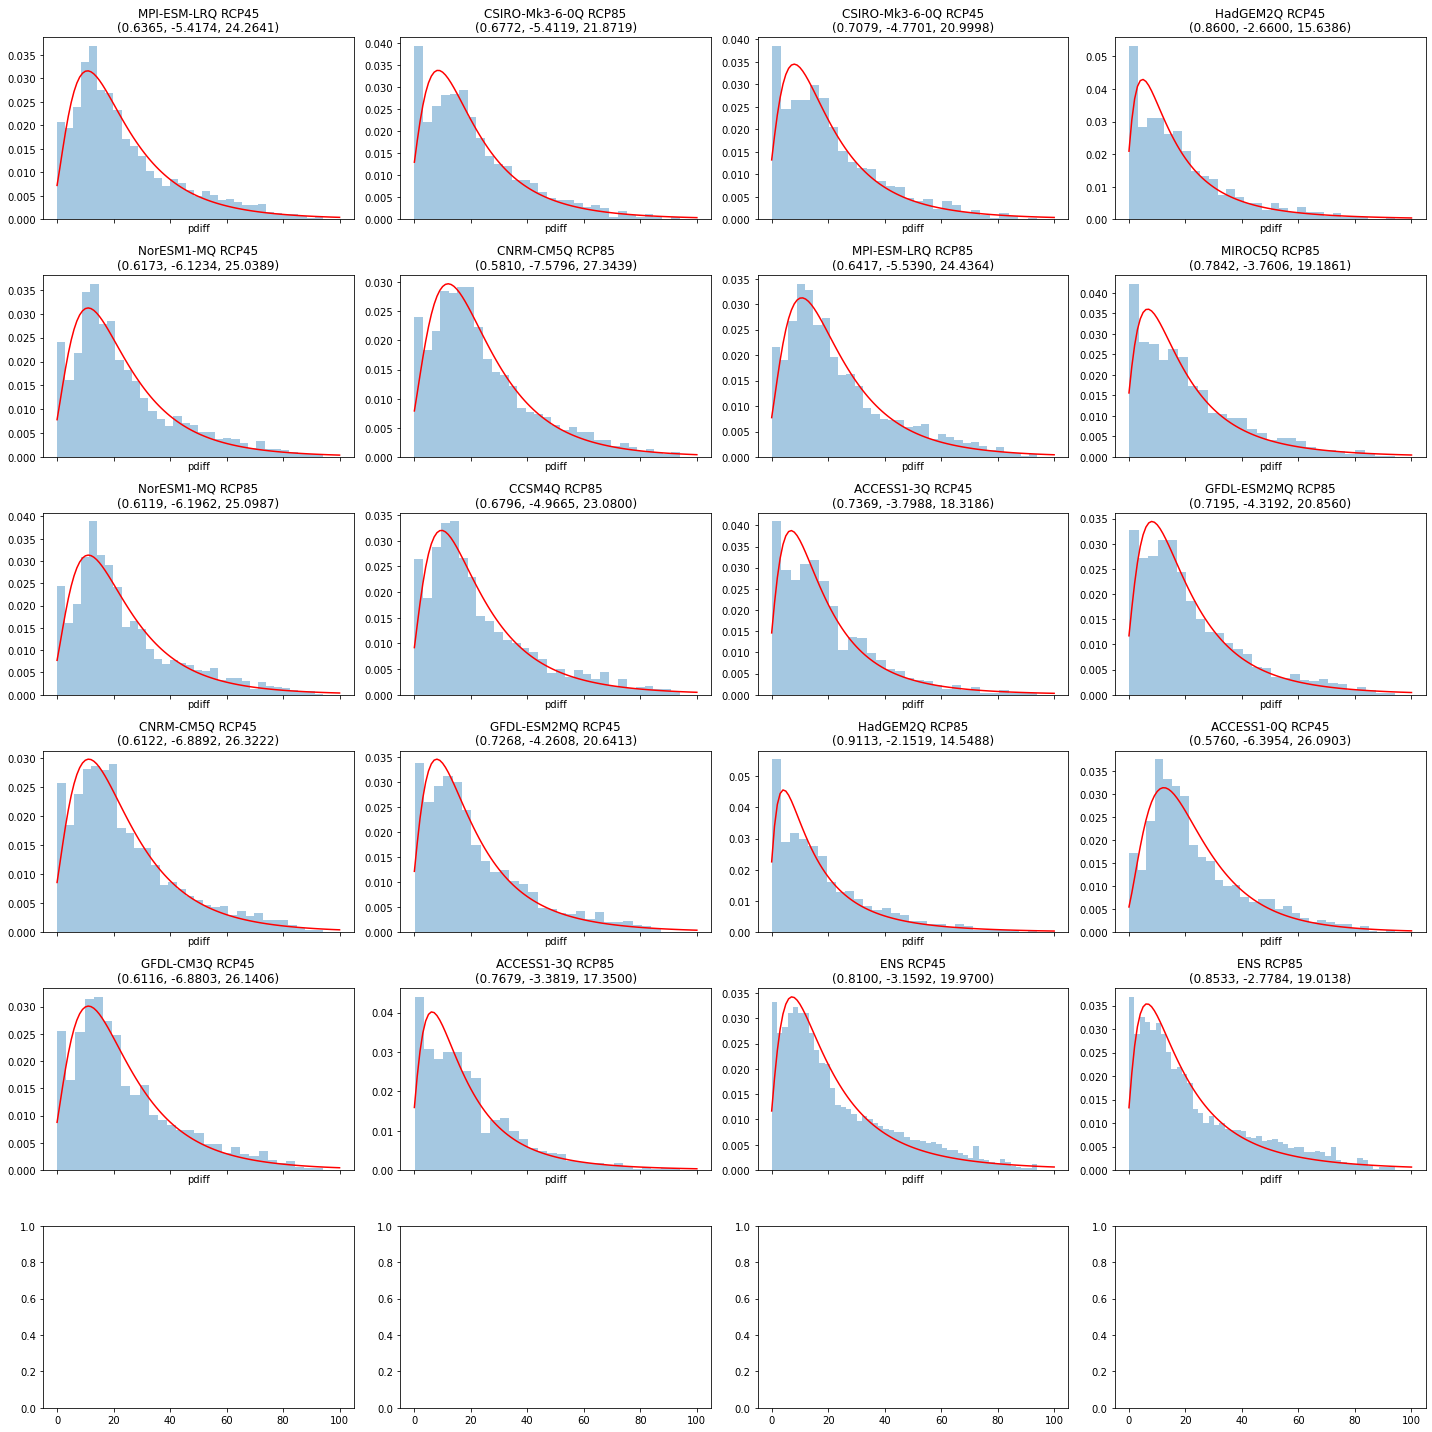

In [17]:
brefparams = plot_model_dists(brefdata)
plt.savefig(pjoin(path, "corrected_reference_distribution.png"), bbox_inches='tight')

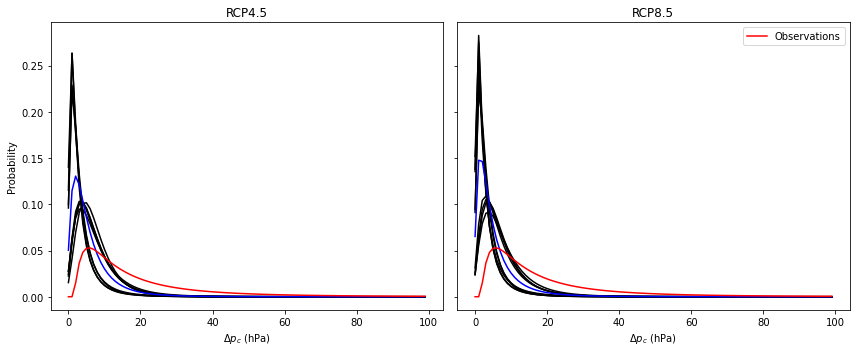

In [18]:
plot_model_params(brefparams)
plt.savefig(pjoin(path, 'corrected_distribution_by_RCP_reference.png'), bbox_inches='tight')

In [19]:
brefparams.groupby(['RCP']).agg('mean')

,mu,sigma,zeta
RCP,,,
RCP45,0.689528,-5.035470,22.342448
RCP85,0.722766,-4.608529,21.278561


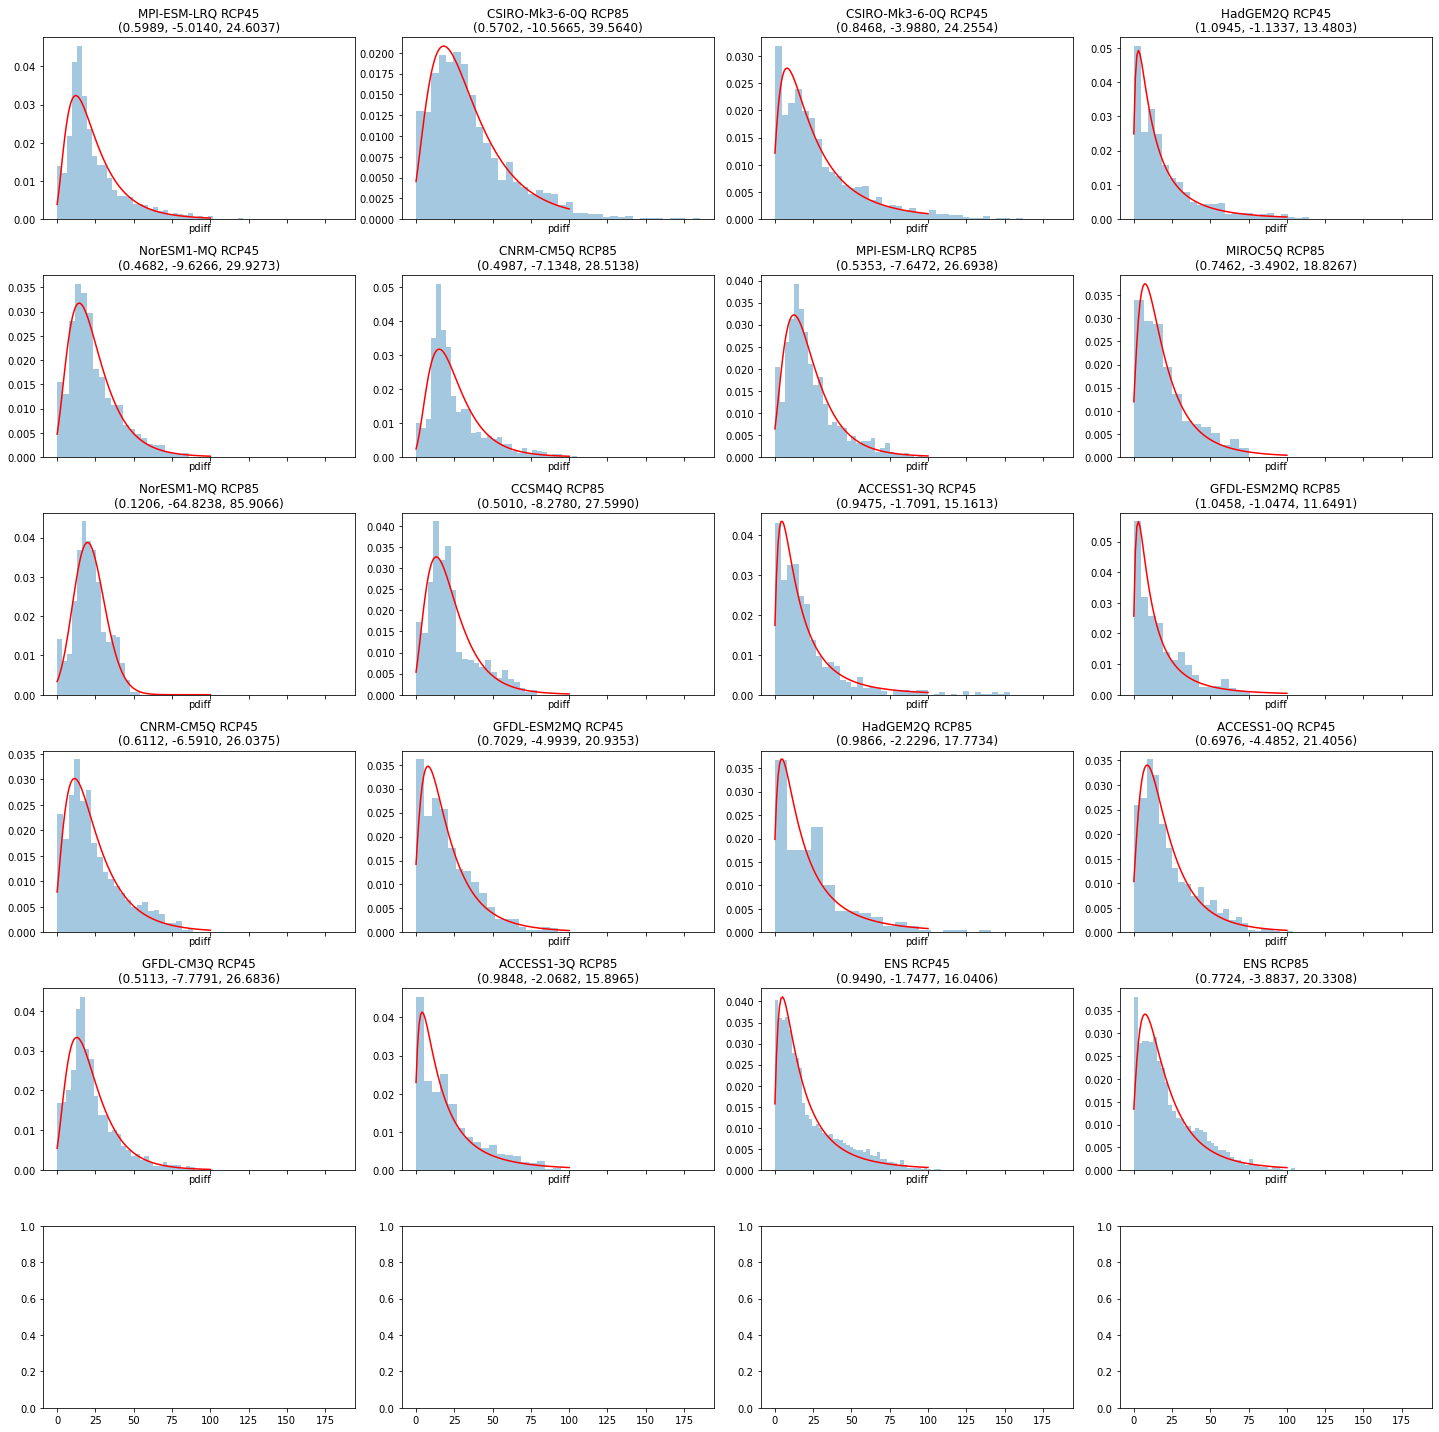

In [20]:
bfutparams = plot_model_dists(bfutdata)
plt.savefig(pjoin(path, "corrected_future_distribution.png"), bbox_inches='tight')

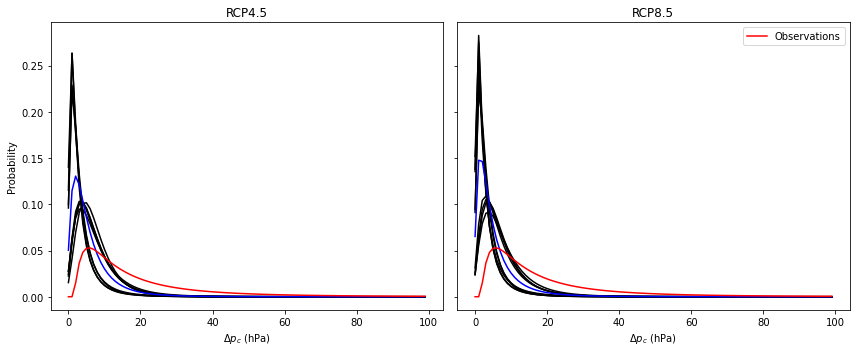

In [21]:
plot_model_params(bfutparams)
plt.savefig(pjoin(path, 'corrected_distribution_by_RCP_future.png'), bbox_inches='tight')

In [22]:
bfutparams.groupby(['RCP']).agg('mean')

,mu,sigma,zeta
RCP,,,
RCP45,0.742788,-4.706839,21.853047
RCP85,0.676163,-11.116928,29.275347


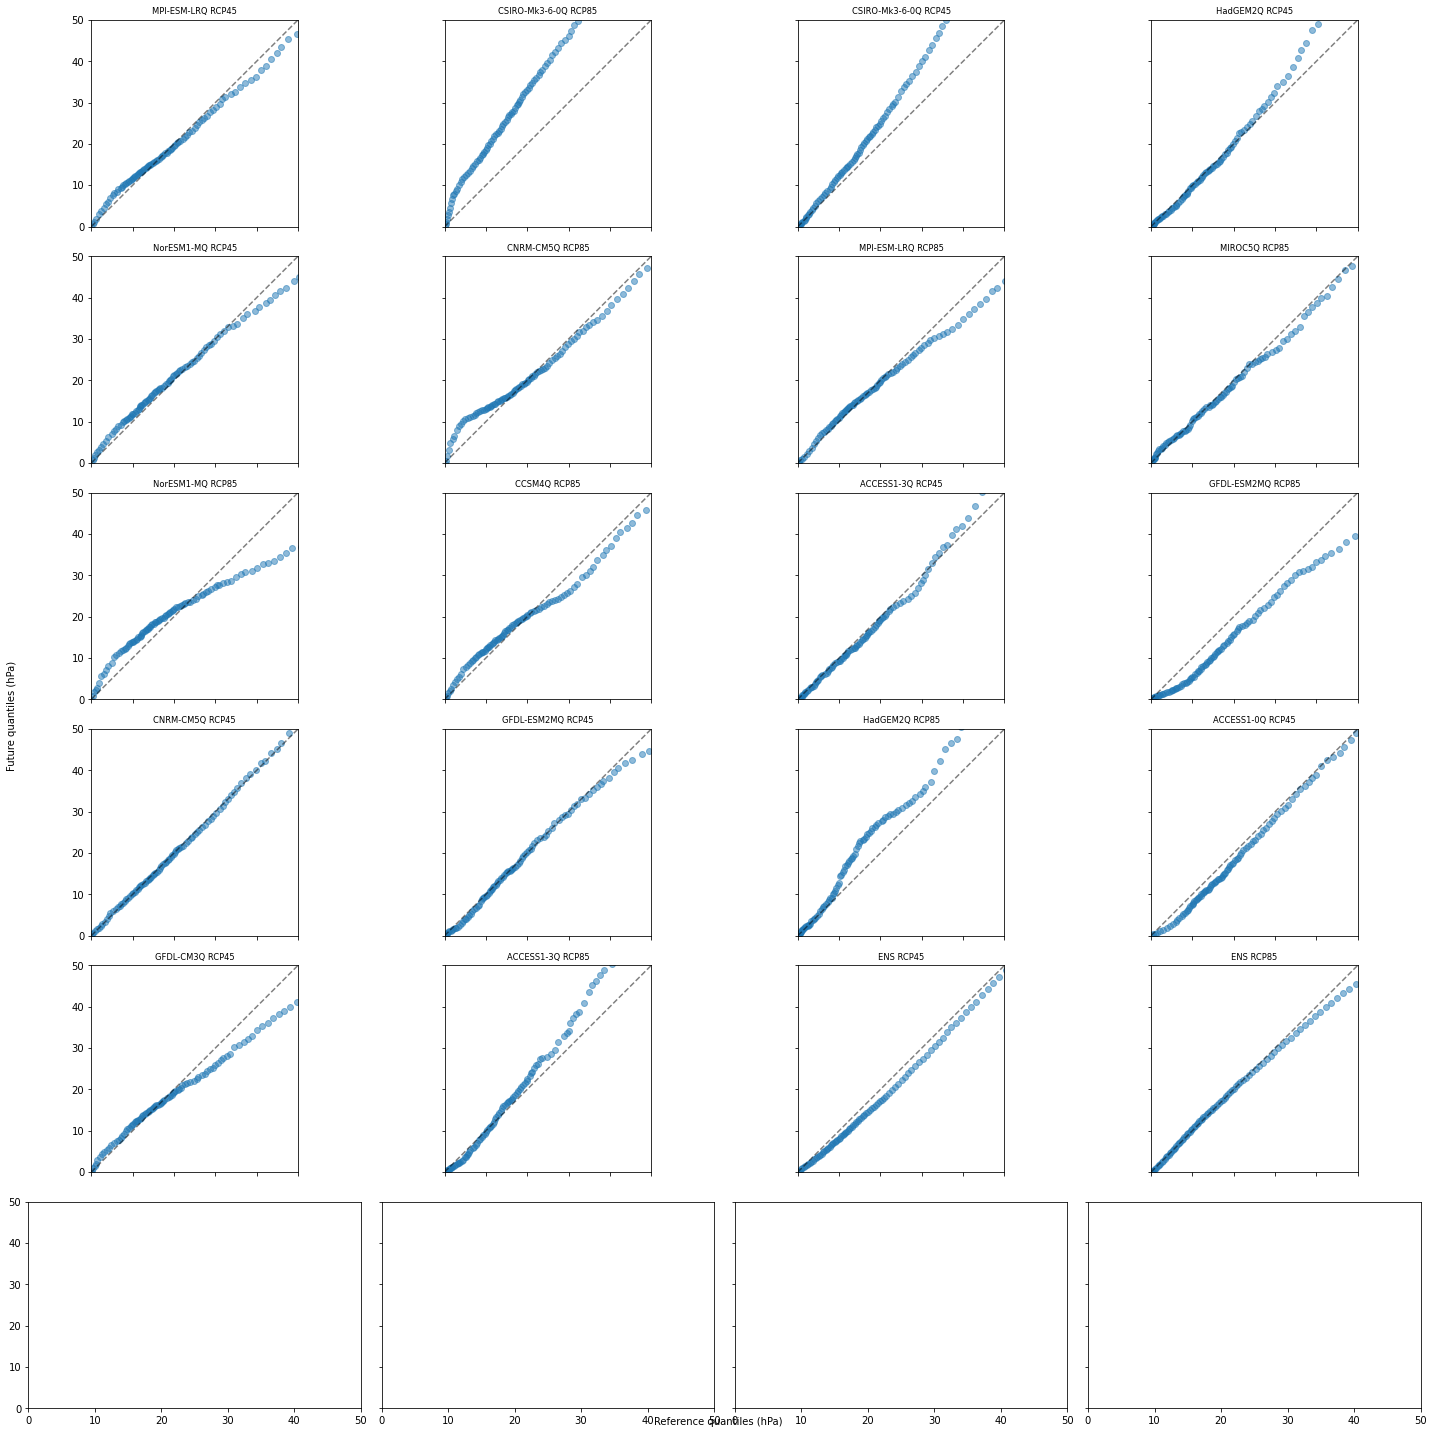

In [23]:
fig, axes = plt.subplots(6, 4, figsize=(20, 20), sharex=True, sharey=True)
ax = axes.flatten()
x = np.linspace(0, 1, 101)
for i, (m, refdf) in enumerate(brefdata.items()):
    futdf = bfutdata[m]
    model, rcp = m.split(' ')

    srefdata = refdf.pdiff.values
    sfutdata = futdf.pdiff.values
    srefq = np.quantile(srefdata, x)
    sfutq = np.quantile(sfutdata, x)
    ax[i].scatter(srefq, sfutq, alpha=0.5)
    ax[i].plot([0, 50], [0,50], '--', color='k', alpha=0.5)
    ax[i].set_title(m, size='small')
    ax[i].set_xlim((0, 50))
    ax[i].set_ylim((0, 50))
    ax[i].set_aspect('equal')
    
fig.tight_layout()
fig.text(0.5, 0.01, "Reference quantiles (hPa)", ha='center', va='center')
fig.text(0.01, 0.5, "Future quantiles (hPa)", ha='center', va='center', rotation='vertical')
plt.savefig(pjoin(path, 'corrected_ref_fut_quantiles.png'), bbox_inches='tight')